In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display

import numpy as np
import sklearn
import torch
import torchaudio
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive 
drive.mount('/content/drive')
import os
from sklearn.metrics import classification_report
import pickle
np.random.seed(12345)

Mounted at /content/drive


In [ ]:
'''
gauth = GoogleAuth()           
drive = GoogleDrive(gauth)  
# read false samples
false_dict = {'name':[], 'id':[]}
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format('13yBGR5nWOgp_U-cbYSi5XZZ0Sr1JxQlj')}).GetList()
for file in file_list:

    false_dict['name'].append(file['title'])
    false_dict['id'].append(file['id'])
    
# read true samples
true_dict = {'name':[], 'id':[]}
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format('1mUhbkiEhDEAZgfpoO85k9yNwnGDdmLR4')}).GetList()
for file in file_list:

    true_dict['name'].append(file['title'])
    true_dict['id'].append(file['id'])
'''
DRIVE_FOLDER = '/content/drive/My Drive/data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/content/drive/My Drive/data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)

In [ ]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/content/drive/My Drive/data/false/'

df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/content/drive/My Drive/data/true/'
# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
df.head

The length of the dataset is:  1,652


<bound method NDFrame.head of                        name  label                                 path
0     Mani_false188 (1).wav      0  /content/drive/My Drive/data/false/
1     Mani_false237 (1).wav      0  /content/drive/My Drive/data/false/
2               Mani259.wav      1   /content/drive/My Drive/data/true/
3         Mani_false248.wav      0  /content/drive/My Drive/data/false/
4         Mani_false493.wav      0  /content/drive/My Drive/data/false/
...                     ...    ...                                  ...
1647            Mani658.wav      1   /content/drive/My Drive/data/true/
1648        Maninoise73.wav      1   /content/drive/My Drive/data/true/
1649        Mani644 (1).wav      1   /content/drive/My Drive/data/true/
1650      Mani_false319.wav      0  /content/drive/My Drive/data/false/
1651      Mani_false395.wav      0  /content/drive/My Drive/data/false/

[1652 rows x 3 columns]>

In [ ]:
#Split the dataset into train and test dataset
trainset, testset = train_test_split(df, test_size=0.30, random_state=100)

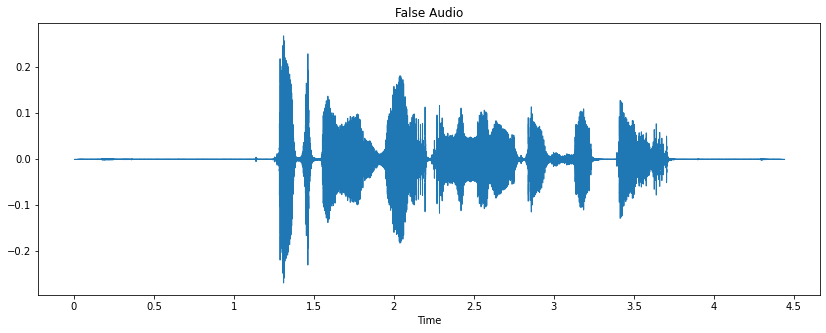

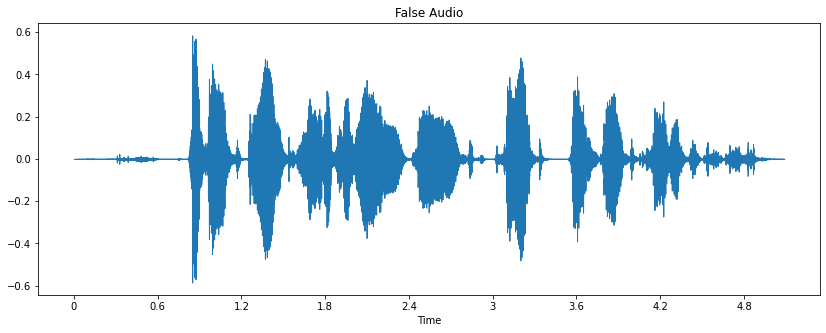

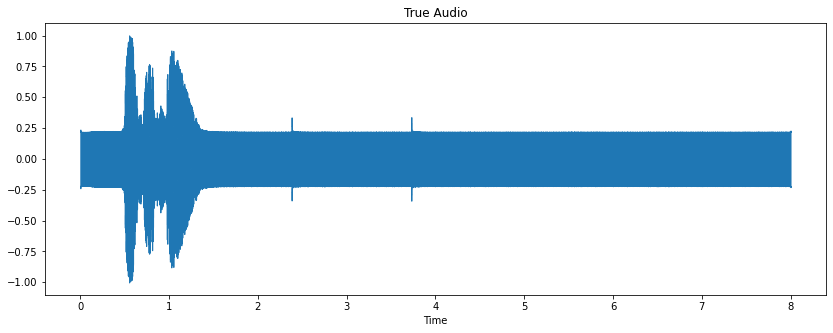

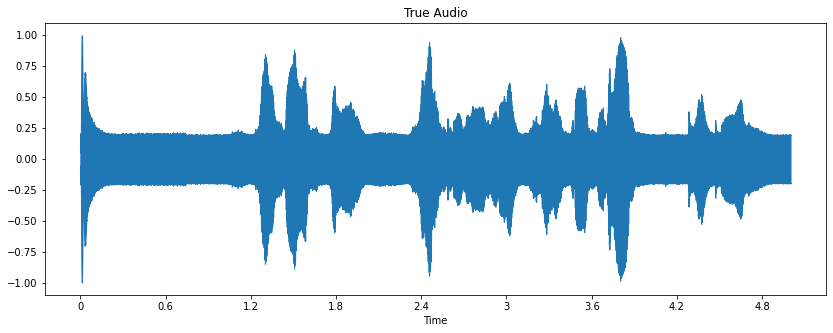

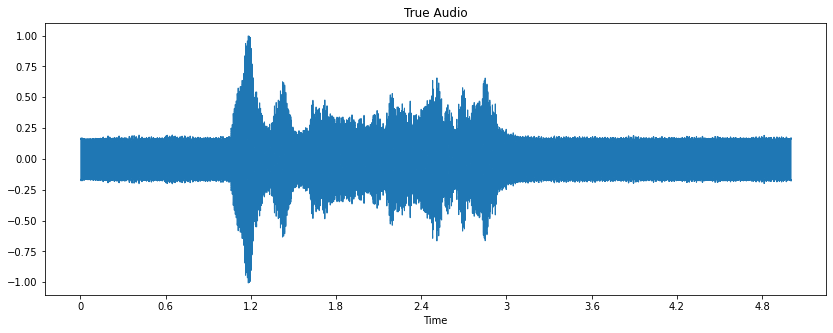

In [ ]:
# View the audio files
n = 5
for i in range(n):

 
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
 
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
        
    plt.title(name)
   

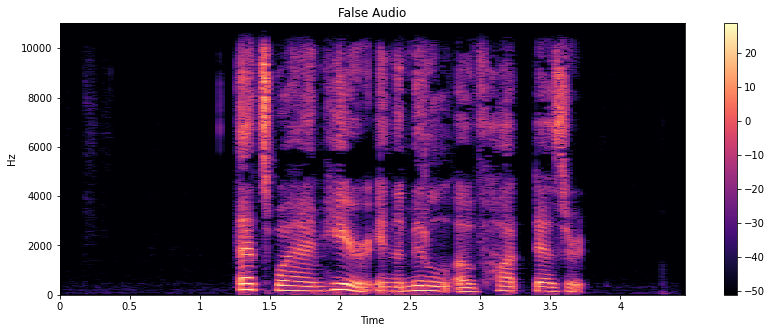

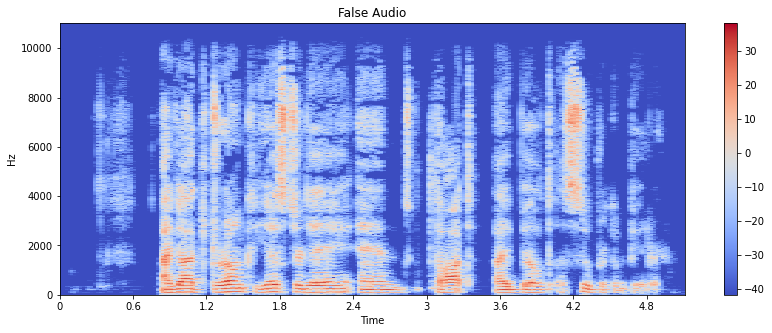

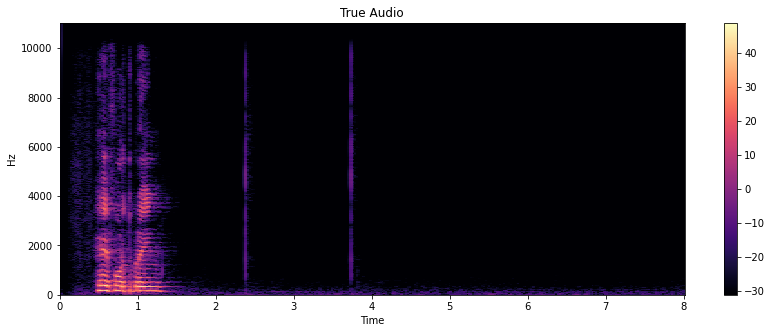

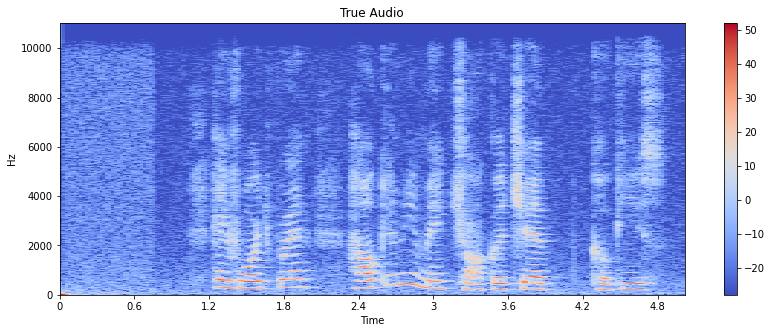

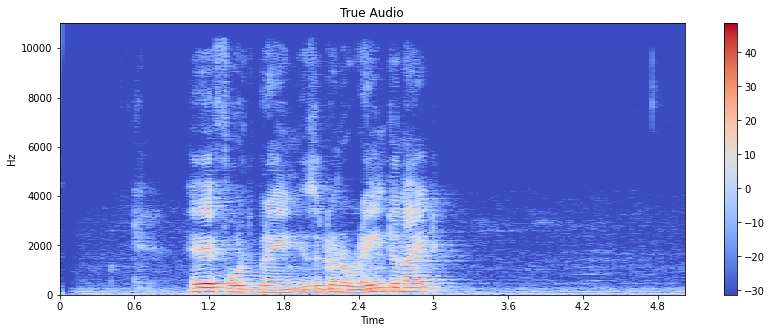

In [ ]:
#Spectogram
n = 5
for i in range(n):

    
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)
    plt.colorbar()

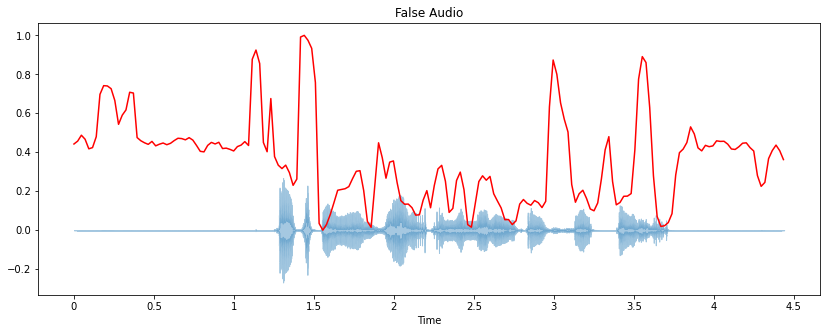

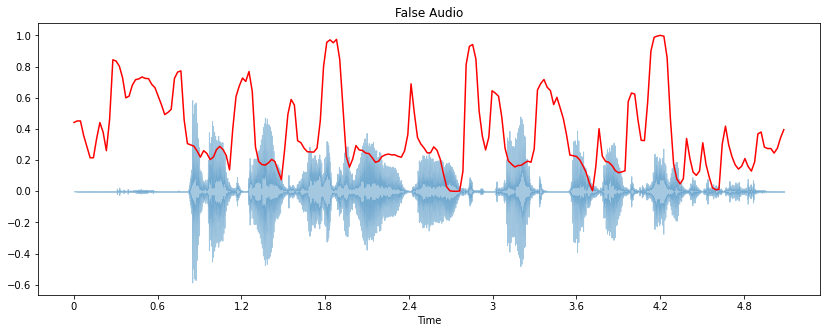

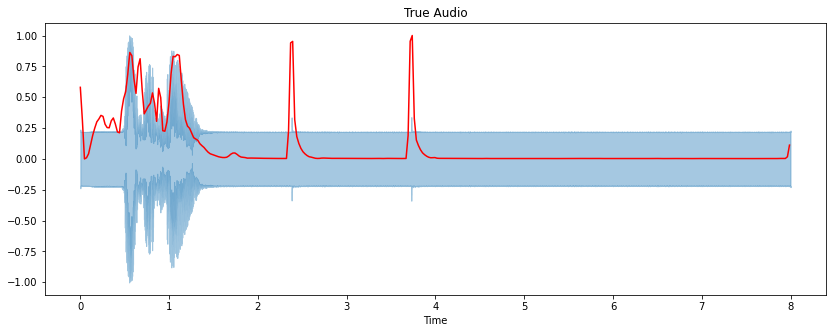

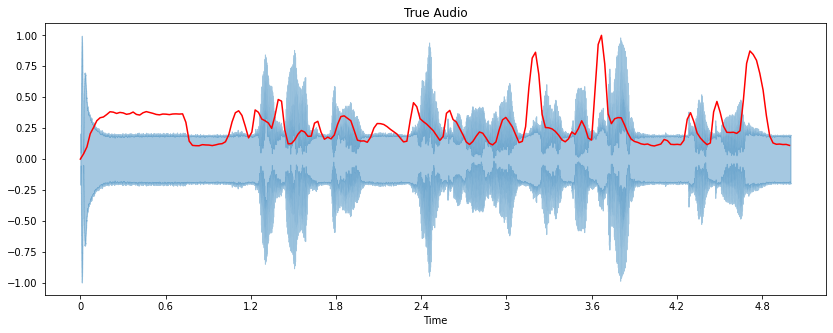

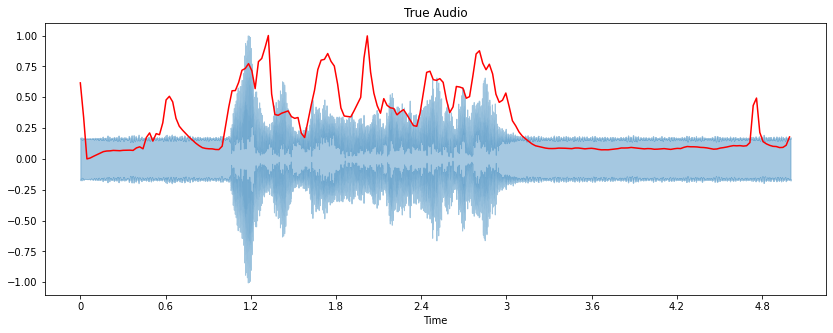

In [ ]:
#spectral centroid

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

n = 5
for i in range(n):
 
    
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    # Normalising the spectral centroid for visualisation
    plt.figure(figsize=(14, 5))
    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)

In [ ]:
def features(df):
    
   
    feature_dict = {'rmse':[],'chroma_stft':[], 'spec_cent':[],'spec_bw':[],'rolloff':[],'zcr':[],'mfcc':[], 'label':[], 
                'rmse_min':[],'chroma_stft_min':[], 'spec_cent_min':[],'spec_bw_min':[],'rolloff_min':[],'zcr_min':[],
                'mfcc_min':[], 'rmse_max':[],'chroma_stft_max':[], 'spec_cent_max':[],'spec_bw_max':[],'rolloff_max':[],'zcr_max':[],
                'mfcc_max':[]}

    for i in tqdm(range(df.shape[0])):
     
  
        
        x , sr = librosa.load(df.iloc[i][2] + df.iloc[i][0])
        rmse = librosa.feature.rms(y=x)
        chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=x, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(x)
        mfcc = librosa.feature.mfcc(y=x, sr=sr)
        
        target = df.iloc[i]['label']
       
        # mean
     
        feature_dict['rmse'].append(np.mean(rmse))
        feature_dict['chroma_stft'].append(np.mean(chroma_stft))
        feature_dict['spec_cent'].append(np.mean(spec_cent))
        feature_dict['spec_bw'].append(np.mean(spec_bw))
        feature_dict['rolloff'].append(np.mean(rolloff))
        feature_dict['zcr'].append(np.mean(zcr))
        feature_dict['mfcc'].append(np.mean(mfcc))
        feature_dict['label'].append(target)
 
        # min
        feature_dict['rmse_min'].append(np.min(rmse))
        feature_dict['chroma_stft_min'].append(np.min(chroma_stft))
        feature_dict['spec_cent_min'].append(np.min(spec_cent))
        feature_dict['spec_bw_min'].append(np.min(spec_bw))
        feature_dict['rolloff_min'].append(np.min(rolloff))
        feature_dict['zcr_min'].append(np.min(zcr))
        feature_dict['mfcc_min'].append(np.min(mfcc))
   
        # max
        feature_dict['rmse_max'].append(np.max(rmse))
        feature_dict['chroma_stft_max'].append(np.max(chroma_stft))
        feature_dict['spec_cent_max'].append(np.max(spec_cent))
        feature_dict['spec_bw_max'].append(np.max(spec_bw))
        feature_dict['rolloff_max'].append(np.max(rolloff))
        feature_dict['zcr_max'].append(np.max(zcr))
        feature_dict['mfcc_max'].append(np.max(mfcc))
        
        
        
    return feature_dict



In [ ]:
#Extract features (train data)
temp = features(trainset)
df_train = pd.DataFrame(temp)
df_train.head



  0%|          | 0/1156 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


<bound method NDFrame.head of           rmse  chroma_stft    spec_cent      spec_bw      rolloff       zcr  \
0     0.014425     0.428490  3315.186968  2827.274111  6575.645828  0.193146   
1     0.044404     0.354161  2569.324297  2130.351189  4758.201682  0.162389   
2     0.229843     0.833100   180.590636   577.476352   279.338697  0.002264   
3     0.215219     0.535672  1377.689012  2199.020468  3200.920614  0.010464   
4     0.188538     0.656726   478.075368  1091.198937   817.015584  0.007191   
...        ...          ...          ...          ...          ...       ...   
1151  0.112508     0.713416   506.334597  1286.206812   719.864343  0.006243   
1152  0.239576     0.745375   747.907006  1595.147504  1353.949992  0.003542   
1153  0.040846     0.355198  2106.098507  1844.637840  3795.666931  0.131777   
1154  0.223829     0.674026  1105.647885  2051.655232  2565.665549  0.004866   
1155  0.232745     0.819977   276.905228   848.961864   409.536557  0.003986   

         

In [ ]:
#Extract features (test data)

temp = features(testset)

df_test = pd.DataFrame(temp)
df_test.head

  0%|          | 0/496 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


<bound method NDFrame.head of          rmse  chroma_stft    spec_cent      spec_bw      rolloff       zcr  \
0    0.037092     0.476619  3208.862799  2596.746705  6142.504524  0.233111   
1    0.064536     0.604004  1737.638366  2217.835094  3783.912150  0.027183   
2    0.164811     0.626853  3214.512380  2289.623983  6064.665664  0.199604   
3    0.035558     0.460209  2721.203035  2070.366089  4911.391135  0.182086   
4    0.043163     0.392669  1880.529203  1914.453123  3860.859819  0.105715   
..        ...          ...          ...          ...          ...       ...   
491  0.034916     0.385617  1675.754098  1797.551387  3334.436566  0.088543   
492  0.175203     0.823706   169.664409   466.930172   314.884086  0.003530   
493  0.097508     0.405633  2356.271055  2355.594754  4840.974010  0.114188   
494  0.139253     0.584536   585.814686  1241.669063  1057.968140  0.008604   
495  0.124083     0.387111  2237.240673  1501.334085  3617.578125  0.178679   

          mfcc  label

In [25]:
#seperate target from features
X_train = df_train.loc[:, df_train.columns != 'label']
y_train = df_train['label']

X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']
print(X_train)

          rmse  chroma_stft    spec_cent      spec_bw      rolloff       zcr  \
0     0.014425     0.428490  3315.186968  2827.274111  6575.645828  0.193146   
1     0.044404     0.354161  2569.324297  2130.351189  4758.201682  0.162389   
2     0.229843     0.833100   180.590636   577.476352   279.338697  0.002264   
3     0.215219     0.535672  1377.689012  2199.020468  3200.920614  0.010464   
4     0.188538     0.656726   478.075368  1091.198937   817.015584  0.007191   
...        ...          ...          ...          ...          ...       ...   
1151  0.112508     0.713416   506.334597  1286.206812   719.864343  0.006243   
1152  0.239576     0.745375   747.907006  1595.147504  1353.949992  0.003542   
1153  0.040846     0.355198  2106.098507  1844.637840  3795.666931  0.131777   
1154  0.223829     0.674026  1105.647885  2051.655232  2565.665549  0.004866   
1155  0.232745     0.819977   276.905228   848.961864   409.536557  0.003986   

           mfcc  rmse_min  chroma_stft_

In [26]:
#Scale the x values
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)

[[0.03068566 0.35998963 0.74373955 ... 0.8588098  0.75410765 0.32749921]
 [0.09774868 0.24929645 0.57164372 ... 0.72695449 0.66288952 0.43585196]
 [0.51258222 0.96254711 0.0204818  ... 0.44574096 0.05892351 0.53550972]
 ...
 [0.08979029 0.25084052 0.46476181 ... 0.79929988 0.77053824 0.58381796]
 [0.49912831 0.72564818 0.2339239  ... 0.5705951  0.03512748 0.53735397]
 [0.51907401 0.94300345 0.04270485 ... 0.72928821 0.06798867 0.58446048]]


In [27]:
#A Neural network model and train

mlp = MLPClassifier(activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(max_iter=500)

In [28]:
# Predict
y_pred = mlp.predict(X_test)

print('The prediction accuracy is: ', round(accuracy_score(y_test, y_pred),2)*100)

The prediction accuracy is:  93.0


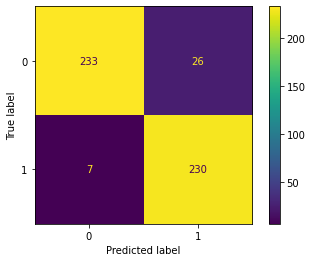

In [29]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)
plt.show()

In [30]:
#Classifcation report
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      0.90      0.93       259
         Yes       0.90      0.97      0.93       237

    accuracy                           0.93       496
   macro avg       0.93      0.94      0.93       496
weighted avg       0.94      0.93      0.93       496



In [31]:
filename = 'MLP.sav'
pickle.dump(mlp, open('/content/drive/MyDrive/Spotify/trained_models/'+filename, 'wb'))

scalerfile = 'scaler.sav'
pickle.dump(sc, open('/content/drive/MyDrive/Spotify/trained_models/'+scalerfile, 'wb'))